In [2]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data")

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation


100%|██████████| 714M/714M [00:06<00:00, 110MB/s] 


In [5]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
from tqdm import tqdm
from scipy.spatial.distance import cdist
import warnings

warnings.filterwarnings("ignore")


In [6]:

# ----------------------------
# 1) CONFIGURATION
# ----------------------------
# Set paths, image sizes, depth, batch size, learning rate, epochs, and random seed
data_dir = "/content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m"
depth = 5                       # number of slices per stack
img_size = (128, 128)           # input size for model
display_size = (256, 256)       # size for displaying predictions
batch_size = 4                  # batch size for training
lr = 1e-3                        # learning rate
num_epochs = 10                  # number of training epochs
seed = 42                        # random seed
save_dir = "results_dynamicnas_lgg"  # directory to save weights and plots
os.makedirs(save_dir, exist_ok=True)

# Set seeds for reproducibility
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
eps = 1e-6  # small epsilon to prevent division by zero


In [7]:

# ----------------------------
# 2) DATA LOADING FUNCTIONS
# ----------------------------
def list_image_mask_pairs_kaggle(root):
    """
    List all image and mask pairs recursively in Kaggle LGG dataset
    """
    mask_paths = sorted(glob(os.path.join(root, "**", "*_mask*"), recursive=True))
    pairs = []
    for m in mask_paths:
        im = m.replace("_mask", "")
        if os.path.exists(im):
            pairs.append((im, m))
    return pairs

def load_image_gray(path, resize_to):
    """
    Load a grayscale image and resize
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.resize(img, resize_to, interpolation=cv2.INTER_LINEAR)
    return (img.astype(np.float32) / 255.0)  # normalize

def load_mask_binary(path, resize_to):
    """
    Load mask as binary image (0 or 1)
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.resize(img, resize_to, interpolation=cv2.INTER_NEAREST)
    return (img > 127).astype(np.uint8)

def build_stacks(pairs, d=5):
    """
    Build stacks of 'd' consecutive slices for 3D input
    """
    imgs = [p[0] for p in pairs]
    msks = [p[1] for p in pairs]
    pad = d // 2
    stacks = []
    for i in range(len(imgs)):
        idxs = [min(max(i + j, 0), len(imgs) - 1) for j in range(-pad, pad + 1)]
        stacks.append(([imgs[k] for k in idxs], [msks[k] for k in idxs]))
    return stacks

def augment_stack(vol, mask):
    """
    Apply random flipping augmentation
    """
    if np.random.rand() > 0.5:
        vol = vol[:, :, ::-1, :]
        mask = mask[:, :, ::-1, :]
    if np.random.rand() > 0.5:
        vol = vol[:, ::-1, :, :]
        mask = mask[:, ::-1, :, :]
    return vol, mask

def stacks_to_tf_dataset_binary(stacks, d=5, size=(128,128), batch=None, augment=False):
    """
    Convert list of stacks to TensorFlow dataset
    """
    def gen():
        for im_paths, mk_paths in stacks:
            vol = np.stack([load_image_gray(p, size) for p in im_paths], 0)[..., None]
            mvol = np.stack([load_mask_binary(p, size) for p in mk_paths], 0)[..., None]
            if augment:
                vol, mvol = augment_stack(vol, mvol)
            yield vol.astype(np.float32), mvol.astype(np.float32)
    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec((d, size[0], size[1], 1), tf.float32),
            tf.TensorSpec((d, size[0], size[1], 1), tf.float32),
        ),
    )
    if batch:
        ds = ds.batch(batch)
    return ds.prefetch(tf.data.AUTOTUNE)

In [8]:
# ----------------------------
# 3) PREPARE DATASET
# ----------------------------
pairs = list_image_mask_pairs_kaggle(data_dir)
if len(pairs) == 0:
    raise RuntimeError(f"No image/mask pairs found at {data_dir}.")

# Split into train/val/test (70%/15%/15%)
random.shuffle(pairs)
n = len(pairs)
train_pairs = pairs[: int(0.7 * n)]
val_pairs   = pairs[int(0.7 * n) : int(0.85 * n)]
test_pairs  = pairs[int(0.85 * n) : ]

# Build 3D stacks for each split
train_stacks = build_stacks(train_pairs, depth)
val_stacks   = build_stacks(val_pairs, depth)
test_stacks  = build_stacks(test_pairs, depth)

# Create TensorFlow datasets
train_ds = stacks_to_tf_dataset_binary(train_stacks, depth, img_size, batch=batch_size, augment=True)
val_ds   = stacks_to_tf_dataset_binary(val_stacks, depth, img_size, batch=batch_size)
test_ds  = stacks_to_tf_dataset_binary(test_stacks, depth, img_size, batch=1)

train_steps = int(np.ceil(len(train_stacks) / batch_size))
val_steps   = int(np.ceil(len(val_stacks) / batch_size))

# DataFrame for test dataset paths
test_df = pd.DataFrame({
    "images_paths": [s[0][depth//2] for s in test_stacks],
    "masks_paths" : [s[1][depth//2] for s in test_stacks],
})

print(f"Found {n} slices -> train {len(train_stacks)}, val {len(val_stacks)}, test {len(test_stacks)}")

Found 3929 slices -> train 2750, val 589, test 590


In [9]:
# ----------------------------
# 4) MODEL BUILDING BLOCKS
# ----------------------------
def conv_block(x, f):
    """
    Simple 3D conv block: Conv3D -> BN -> ReLU -> Conv3D -> BN -> ReLU
    """
    x = layers.Conv3D(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv3D(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def dynamic_gate(enc, dec, ch):
    """
    Dynamic fusion gate between encoder and decoder feature maps
    """
    enc_p = layers.Conv3D(ch, 1, padding="same")(enc)
    dec_p = layers.Conv3D(ch, 1, padding="same")(dec)
    fused = layers.Concatenate()([enc_p, dec_p])
    gap = layers.GlobalAveragePooling3D()(fused)
    att = layers.Dense(max(ch // 8, 1), activation="relu")(gap)
    att = layers.Dense(ch, activation="sigmoid")(att)
    att = layers.Reshape((1, 1, 1, ch))(att)
    return enc_p * att + dec_p * (1 - att)

def nas_decoder_block(x, f):
    """
    NAS-style decoder block combining multiple kernel sizes
    """
    p1 = layers.Conv3D(f, 3, padding="same", activation="relu")(x)
    p2 = layers.Conv3D(f, 5, padding="same", activation="relu")(x)
    p3 = layers.Conv3D(f, 1, padding="same", activation="relu")(x)
    merged = layers.Add()([p1, p2, p3])
    merged = layers.BatchNormalization()(merged)
    return layers.ReLU()(merged)

def build_encoder(inputs, enc_type="effidec3d", base=16):
    """
    Build encoder with 3D convolutions based on chosen architecture
    """
    def res_conv_block(x, f, dilation_rate=1):
        y = layers.Conv3D(f, 3, padding="same", dilation_rate=dilation_rate)(x)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.Conv3D(f, 3, padding="same", dilation_rate=dilation_rate)(y)
        y = layers.BatchNormalization()(y)
        if x.shape[-1] != f:
            x = layers.Conv3D(f, 1, padding="same")(x)
            x = layers.BatchNormalization()(x)
        return layers.ReLU()(layers.Add()([x, y]))

    if enc_type == "mednext":
        c1 = conv_block(inputs, base * 2)
        p1 = layers.MaxPool3D((1, 2, 2))(c1)
        c2 = conv_block(p1, base * 4)
        p2 = layers.MaxPool3D((1, 2, 2))(c2)
        c3 = conv_block(p2, base * 8)
        p3 = layers.MaxPool3D((1, 2, 2))(c3)
    elif enc_type == "3dux":
        r1 = res_conv_block(inputs, base)
        p1 = layers.MaxPool3D((1, 2, 2))(r1)
        r2 = res_conv_block(p1, base * 2)
        p2 = layers.MaxPool3D((1, 2, 2))(r2)
        r3 = res_conv_block(p2, base * 4)
        p3 = layers.MaxPool3D((1, 2, 2))(r3)
        c1, c2, c3 = r1, r2, r3
    else:  # effidec3d default
        c1 = conv_block(inputs, base)
        p1 = layers.MaxPool3D((1, 2, 2))(c1)
        c2 = conv_block(p1, base * 2)
        p2 = layers.MaxPool3D((1, 2, 2))(c2)
        c3 = conv_block(p2, base * 4)
        p3 = layers.MaxPool3D((1, 2, 2))(c3)
    return c1, c2, c3, p3

def build_dynamicnas_model(shape=(5,128,128,1), base=16, enc_type="effidec3d"):
    """
    Build full 3D DynamicNAS segmentation model
    """
    inp = keras.Input(shape=shape)
    c1, c2, c3, p3 = build_encoder(inp, enc_type, base)
    b = nas_decoder_block(p3, base * 8)
    u3 = layers.UpSampling3D((1,2,2))(b)
    u3 = dynamic_gate(c3, u3, base*4)
    u3 = nas_decoder_block(u3, base*4)
    u2 = layers.UpSampling3D((1,2,2))(u3)
    u2 = dynamic_gate(c2, u2, base*2)
    u2 = nas_decoder_block(u2, base*2)
    u1 = layers.UpSampling3D((1,2,2))(u2)
    u1 = dynamic_gate(c1, u1, base)
    u1 = nas_decoder_block(u1, base)
    out = layers.Conv3D(1, 1, activation=None)(u1)
    return keras.Model(inp, out, name=f"{enc_type}_EffiDec3D_DynamicNAS")

In [10]:
# ----------------------------
# 5) LOSS AND METRICS
# ----------------------------
def dice_metric_soft(y_true, y_pred):
    """
    Soft Dice coefficient for training
    """
    p = tf.nn.sigmoid(y_pred)
    inter = tf.reduce_sum(p * y_true, axis=[1,2,3,4])
    denom = tf.reduce_sum(p, axis=[1,2,3,4]) + tf.reduce_sum(y_true, axis=[1,2,3,4])
    return tf.reduce_mean((2.0*inter + eps)/(denom + eps))

def iou_metric_soft(y_true, y_pred):
    """
    Soft IoU coefficient for training
    """
    p = tf.nn.sigmoid(y_pred)
    inter = tf.reduce_sum(p * y_true, axis=[1,2,3,4])
    union = tf.reduce_sum(p + y_true, axis=[1,2,3,4]) - inter
    return tf.reduce_mean((inter + eps)/(union + eps))

def binary_acc_metric(y_true, y_pred):
    """
    Binary accuracy metric
    """
    p = tf.nn.sigmoid(y_pred)
    p = tf.cast(p > 0.5, tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(p, tf.cast(y_true, tf.float32)), tf.float32))

def weighted_bce_dice_loss(pos_weight=10.0):
    """
    Combined weighted BCE + Dice loss
    """
    def loss(y_true, y_pred):
        wc = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=pos_weight)
        probs = tf.nn.sigmoid(y_pred)
        inter = 2*tf.reduce_sum(probs*y_true, axis=[1,2,3,4]) + eps
        denom = tf.reduce_sum(probs, axis=[1,2,3,4]) + tf.reduce_sum(y_true, axis=[1,2,3,4]) + eps
        dice = 1.0 - (inter/denom)
        return 0.4*tf.reduce_mean(wc) + 0.6*tf.reduce_mean(dice)
    return loss


In [11]:
# ----------------------------
# 6) HD95 EVALUATION
# ----------------------------
def hd95(true_mask, pred_mask):
    """
    Compute 95% Hausdorff Distance between binary masks
    """
    A = np.argwhere(true_mask>0)
    B = np.argwhere(pred_mask>0)
    if A.size==0 and B.size==0: return 0.0
    if A.size==0 or B.size==0: return float(np.max(true_mask.shape))
    dists_AB = cdist(A,B)
    d_AB = np.percentile(np.min(dists_AB, axis=1),95)
    d_BA = np.percentile(np.min(dists_AB, axis=0),95)
    return float(max(d_AB,d_BA))

def binary_eval_on_dataset(model, ds, max_batches=None):
    """
    Evaluate dataset slice-by-slice with Dice & HD95
    """
    dices = []
    hds = []
    for i,(x_batch,y_batch) in enumerate(ds):
        if max_batches is not None and i>=max_batches:
            break
        logits = model.predict(x_batch, verbose=0)
        probs = tf.nn.sigmoid(logits).numpy()
        preds = (probs>0.5).astype(np.uint8)
        gts = (y_batch.numpy()>0.5).astype(np.uint8)
        for b in range(preds.shape[0]):
            p = preds[b,...,0]
            g = gts[b,...,0]
            denom = np.sum(p)+np.sum(g)
            dices.append((2*np.sum(p*g)+eps)/(denom+eps) if denom>0 else 1.0)
            hds.append(hd95(g,p))
    if len(dices)==0: return {"dice_mean": np.nan,"hd95_mean": np.nan,"count":0}
    return {"dice_mean": float(np.mean(dices)),
            "dice_std": float(np.std(dices)),
            "hd95_mean": float(np.mean(hds)),
            "hd95_std": float(np.std(hds)),
            "count": len(dices)}


In [12]:

# ----------------------------
# 7) PREDICTION VISUALIZATION HELPERS
# ----------------------------
def prepare_input_for_model(img_path, model, resize_to=(128,128), display_size=(256,256)):
    """
    Prepare a single image for model prediction and display
    """
    img_bgr = cv2.imread(img_path)
    if img_bgr.ndim==3 and img_bgr.shape[2]==3:
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img_bgr.copy()
    disp = cv2.resize(img_gray, display_size)
    H,W = resize_to
    img_small = cv2.resize(img_gray, (W,H)).astype("float32")/255.0
    inp_shape = model.input_shape
    if len(inp_shape)==5:
        D = inp_shape[1]
        stack = np.stack([img_small for _ in range(D)], axis=0)[...,None]
        stack = np.expand_dims(stack, axis=0)
        return stack, disp
    else:
        return img_small[...,None][None,...], disp

def plot_prediction(img_disp, mask_pred, alpha=0.4, save_path=None):
    """
    Plot predicted mask overlayed on image
    """
    plt.figure(figsize=(6,6))
    plt.imshow(img_disp, cmap='gray')
    plt.imshow(mask_pred, cmap='Reds', alpha=alpha)
    plt.title("Sample Prediction")
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()


In [13]:

# ----------------------------
# 8) PLOT TRAINING HISTORY
# ----------------------------
def plot_training_history(history, save_path=None):
    """
    Plot Training and Validation Accuracy, IoU, Dice, Loss in 2x2 grid
    """
    acc = history.get('binary_acc_metric', history.get('accuracy'))
    val_acc = history.get('val_binary_acc_metric', history.get('val_accuracy'))

    iou = history.get('iou_metric_soft', history.get('iou_metric'))
    val_iou = history.get('val_iou_metric_soft', history.get('val_iou_metric'))

    dice = history.get('dice_metric_soft', history.get('dice_metric'))
    val_dice = history.get('val_dice_metric_soft', history.get('val_dice_metric'))

    loss = history.get('loss')
    val_loss = history.get('val_loss')

    epochs = range(1, len(loss)+1)

    fig, axes = plt.subplots(2,2, figsize=(12,10))

    axes[0,0].plot(epochs, acc, label='Train Acc')
    axes[0,0].plot(epochs, val_acc, label='Val Acc')
    axes[0,0].set_title('Training and Validation Accuracy')
    axes[0,0].legend(); axes[0,0].grid(True)

    axes[0,1].plot(epochs, iou, label='Train IoU')
    axes[0,1].plot(epochs, val_iou, label='Val IoU')
    axes[0,1].set_title('Training and Validation IoU')
    axes[0,1].legend(); axes[0,1].grid(True)

    axes[1,0].plot(epochs, dice, label='Train Dice')
    axes[1,0].plot(epochs, val_dice, label='Val Dice')
    axes[1,0].set_title('Training and Validation Dice')
    axes[1,0].legend(); axes[1,0].grid(True)

    axes[1,1].plot(epochs, loss, label='Train Loss')
    axes[1,1].plot(epochs, val_loss, label='Val Loss')
    axes[1,1].set_title('Training and Validation Loss')
    axes[1,1].legend(); axes[1,1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()


Test sizing -> ts_length=590, test_batch_size=59, test_steps=10

========== MedNeXtMK3w/EffiDec3D ==========


Model: "mednext_EffiDec3D_DynamicNAS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 5, 128, 128, 1)       │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d (Conv3D)                   │ (None, 5, 128, 128, 32)      │               896 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization               │ (None, 5, 128, 128, 32)      │               128 │ conv3d[0][0]              
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu (ReLU)                      │ (None, 5, 128, 128, 32)      │                 0 │ batch_normalization[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_1 (Conv3D)                 │ (None, 5, 128, 128, 32)      │            27,680 │ re_lu[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_1             │ (None, 5, 128, 128, 32)      │               128 │ conv3d_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_1 (ReLU)                    │ (None, 5, 128, 128, 32)      │                 0 │ batch_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling3d (MaxPooling3D)      │ (None, 5, 64, 64, 32)        │                 0 │ re_lu_1[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_2 (Conv3D)                 │ (None, 5, 64, 64, 64)        │            55,360 │ max_pooling3d[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_2             │ (None, 5, 64, 64, 64)        │               256 │ conv3d_2[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_2 (ReLU)                    │ (None, 5, 64, 64, 64)        │                 0 │ batch_normalization_2[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_3 (Conv3D)                 │ (None, 5, 64, 64, 64)        │           110,656 │ re_lu_2[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_3             │ (None, 5, 64, 64, 64)        │               256 │ conv3d_3[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_3 (ReLU)                    │ (None, 5, 64, 64, 64)        │                 0 │ batch_normalization_3[0][0
├───────────────────────────────────┼───────────────────

 Total params: 4,215,039 (16.08 MB)

 Trainable params: 4,213,663 (16.07 MB)

 Non-trainable params: 1,376 (5.38 KB)

Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 297s 374ms/step - binary_acc_metric: 0.9179 - dice_metric_soft: 0.0571 - iou_metric_soft: 0.0304 - loss: 0.7245 - val_binary_acc_metric: 0.9513 - val_dice_metric_soft: 0.1294 - val_iou_metric_soft: 0.0722 - val_loss: 0.5966
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9513 - val_dice_metric_soft: 0.1294 - val_iou_metric_soft: 0.0722 - val_loss: 0.5966
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 231s 336ms/step - binary_acc_metric: 0.9721 - dice_metric_soft: 0.1629 - iou_metric_soft: 0.0951 - loss: 0.5856 - val_binary_acc_metric: 0.9772 - val_dice_metric_soft: 0.1790 - val_iou_metric_soft: 0.1061 - val_loss: 0.5643
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9

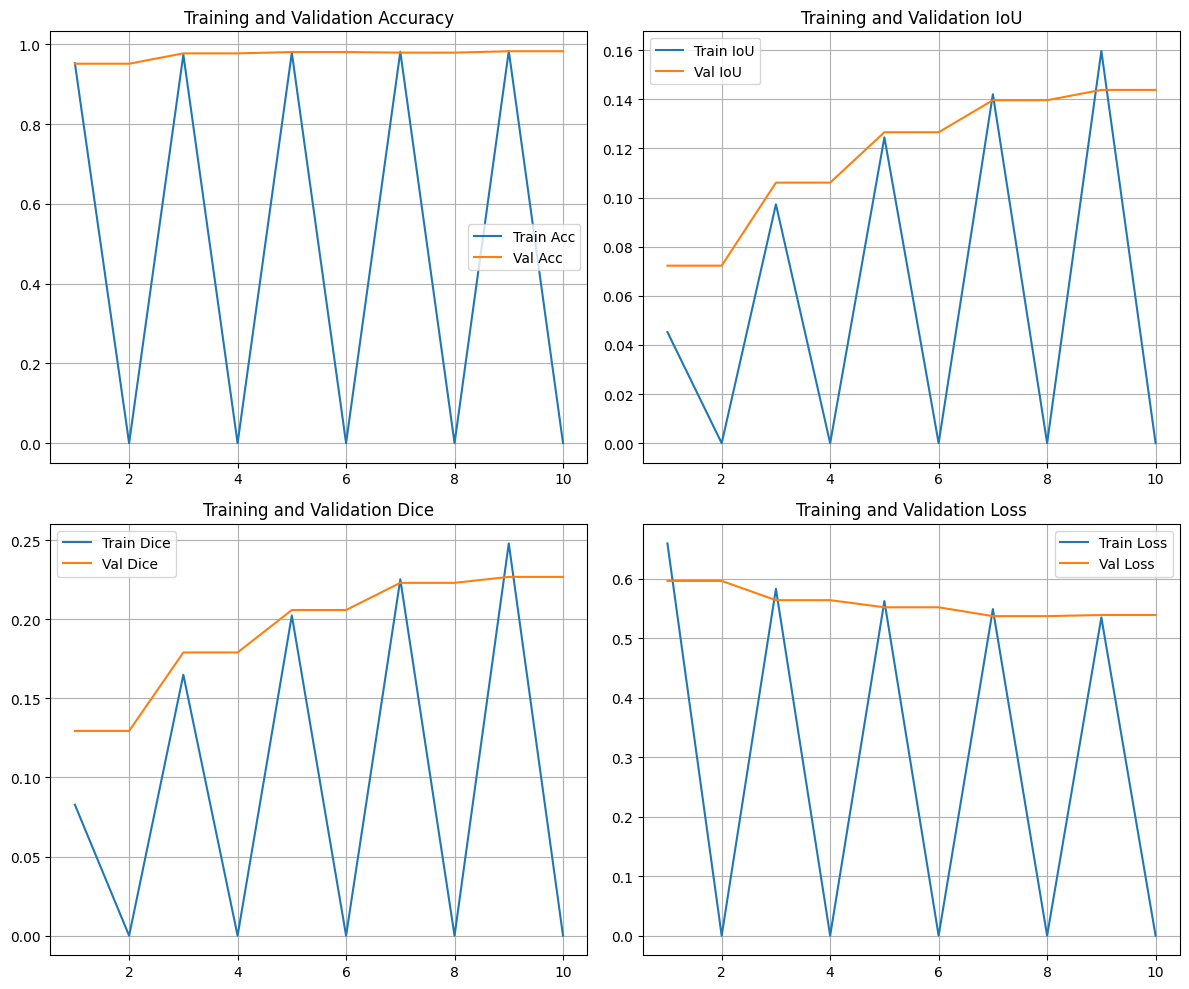

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


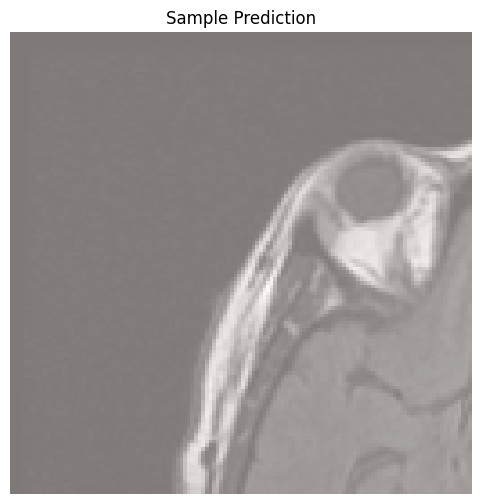


========== SwinUNETRw/EffiDec3D ==========


Model: "swinunetr_EffiDec3D_DynamicNAS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_1 (InputLayer)        │ (None, 5, 128, 128, 1)       │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_25 (Conv3D)                │ (None, 5, 128, 128, 16)      │               448 │ input_layer_1[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_10            │ (None, 5, 128, 128, 16)      │                64 │ conv3d_25[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_10 (ReLU)                   │ (None, 5, 128, 128, 16)      │                 0 │ batch_normalization_10[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_26 (Conv3D)                │ (None, 5, 128, 128, 16)      │             6,928 │ re_lu_10[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_11            │ (None, 5, 128, 128, 16)      │                64 │ conv3d_26[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_11 (ReLU)                   │ (None, 5, 128, 128, 16)      │                 0 │ batch_normalization_11[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling3d_3 (MaxPooling3D)    │ (None, 5, 64, 64, 16)        │                 0 │ re_lu_11[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_27 (Conv3D)                │ (None, 5, 64, 64, 32)        │            13,856 │ max_pooling3d_3[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_12            │ (None, 5, 64, 64, 32)        │               128 │ conv3d_27[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_12 (ReLU)                   │ (None, 5, 64, 64, 32)        │                 0 │ batch_normalization_12[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_28 (Conv3D)                │ (None, 5, 64, 64, 32)        │            27,680 │ re_lu_12[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_13            │ (None, 5, 64, 64, 32)        │               128 │ conv3d_28[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_13 (ReLU)                   │ (None, 5, 64, 64, 32)        │                 0 │ batch_normalization_13[0][
├───────────────────────────────────┼───────────────────

 Total params: 2,311,919 (8.82 MB)

 Trainable params: 2,310,991 (8.82 MB)

 Non-trainable params: 928 (3.62 KB)

Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 215s 275ms/step - binary_acc_metric: 0.9177 - dice_metric_soft: 0.0653 - iou_metric_soft: 0.0350 - loss: 0.7017 - val_binary_acc_metric: 0.9783 - val_dice_metric_soft: 0.1630 - val_iou_metric_soft: 0.0952 - val_loss: 0.5906
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9783 - val_dice_metric_soft: 0.1630 - val_iou_metric_soft: 0.0952 - val_loss: 0.5906
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 173s 252ms/step - binary_acc_metric: 0.9742 - dice_metric_soft: 0.1749 - iou_metric_soft: 0.1032 - loss: 0.5784 - val_binary_acc_metric: 0.9849 - val_dice_metric_soft: 0.1812 - val_iou_metric_soft: 0.1110 - val_loss: 0.6036
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9

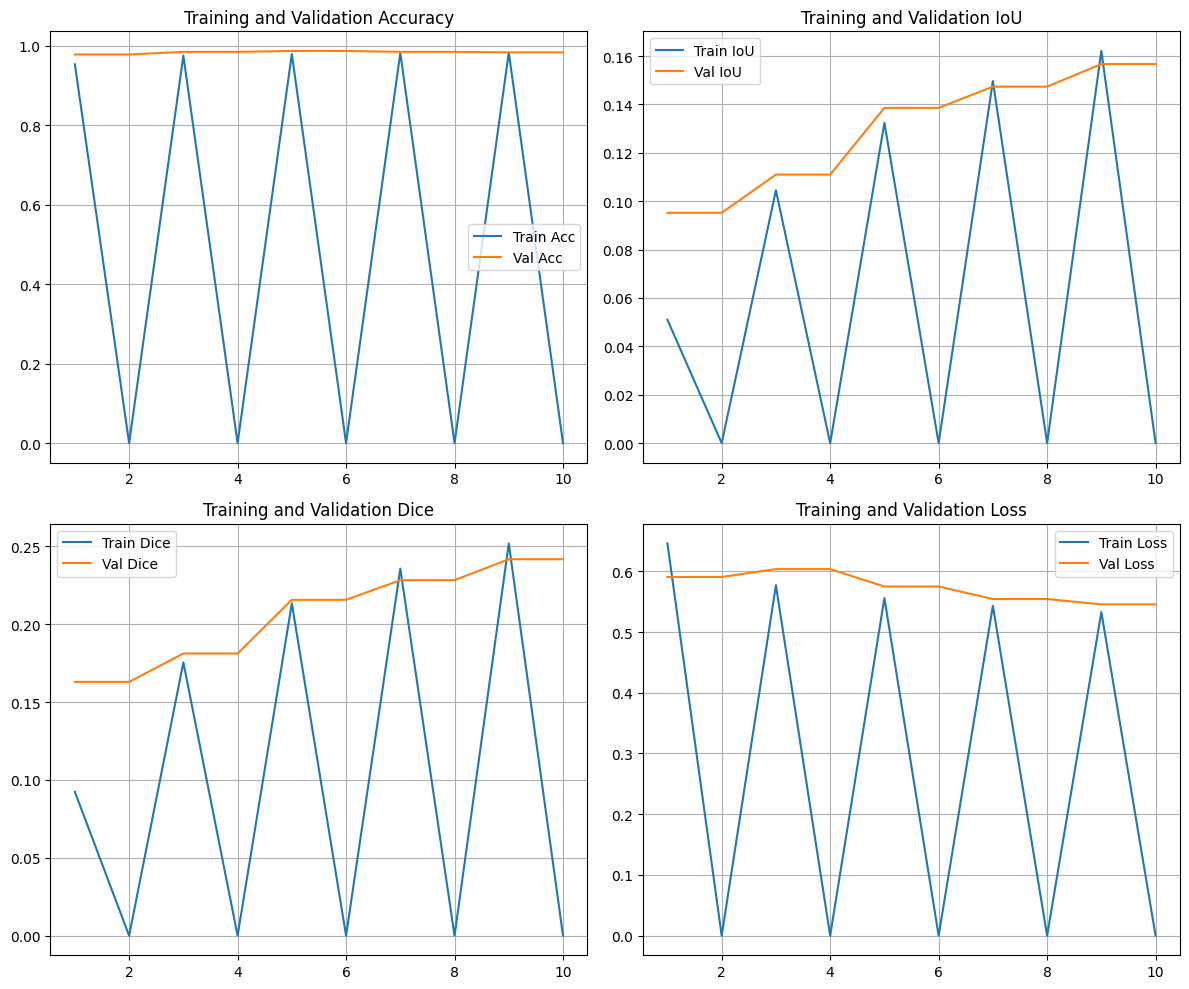

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


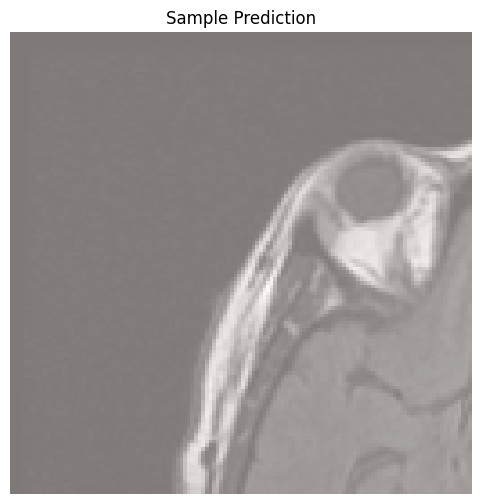


========== SwinUNETRv2w/EffiDec3D ==========


Model: "swinunetrv2_EffiDec3D_DynamicNAS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_2 (InputLayer)        │ (None, 5, 128, 128, 1)       │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_50 (Conv3D)                │ (None, 5, 128, 128, 16)      │               448 │ input_layer_2[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_20            │ (None, 5, 128, 128, 16)      │                64 │ conv3d_50[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_20 (ReLU)                   │ (None, 5, 128, 128, 16)      │                 0 │ batch_normalization_20[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_51 (Conv3D)                │ (None, 5, 128, 128, 16)      │             6,928 │ re_lu_20[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_21            │ (None, 5, 128, 128, 16)      │                64 │ conv3d_51[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_21 (ReLU)                   │ (None, 5, 128, 128, 16)      │                 0 │ batch_normalization_21[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling3d_6 (MaxPooling3D)    │ (None, 5, 64, 64, 16)        │                 0 │ re_lu_21[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_52 (Conv3D)                │ (None, 5, 64, 64, 32)        │            13,856 │ max_pooling3d_6[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_22            │ (None, 5, 64, 64, 32)        │               128 │ conv3d_52[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_22 (ReLU)                   │ (None, 5, 64, 64, 32)        │                 0 │ batch_normalization_22[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_53 (Conv3D)                │ (None, 5, 64, 64, 32)        │            27,680 │ re_lu_22[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_23            │ (None, 5, 64, 64, 32)        │               128 │ conv3d_53[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_23 (ReLU)                   │ (None, 5, 64, 64, 32)        │                 0 │ batch_normalization_23[0][
├───────────────────────────────────┼───────────────────

 Total params: 2,311,919 (8.82 MB)

 Trainable params: 2,310,991 (8.82 MB)

 Non-trainable params: 928 (3.62 KB)

Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 214s 275ms/step - binary_acc_metric: 0.9395 - dice_metric_soft: 0.0793 - iou_metric_soft: 0.0431 - loss: 0.6702 - val_binary_acc_metric: 0.9769 - val_dice_metric_soft: 0.1748 - val_iou_metric_soft: 0.1035 - val_loss: 0.5913
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9769 - val_dice_metric_soft: 0.1748 - val_iou_metric_soft: 0.1035 - val_loss: 0.5913
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 174s 253ms/step - binary_acc_metric: 0.9745 - dice_metric_soft: 0.1809 - iou_metric_soft: 0.1074 - loss: 0.5752 - val_binary_acc_metric: 0.9826 - val_dice_metric_soft: 0.1780 - val_iou_metric_soft: 0.1058 - val_loss: 0.5981
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9

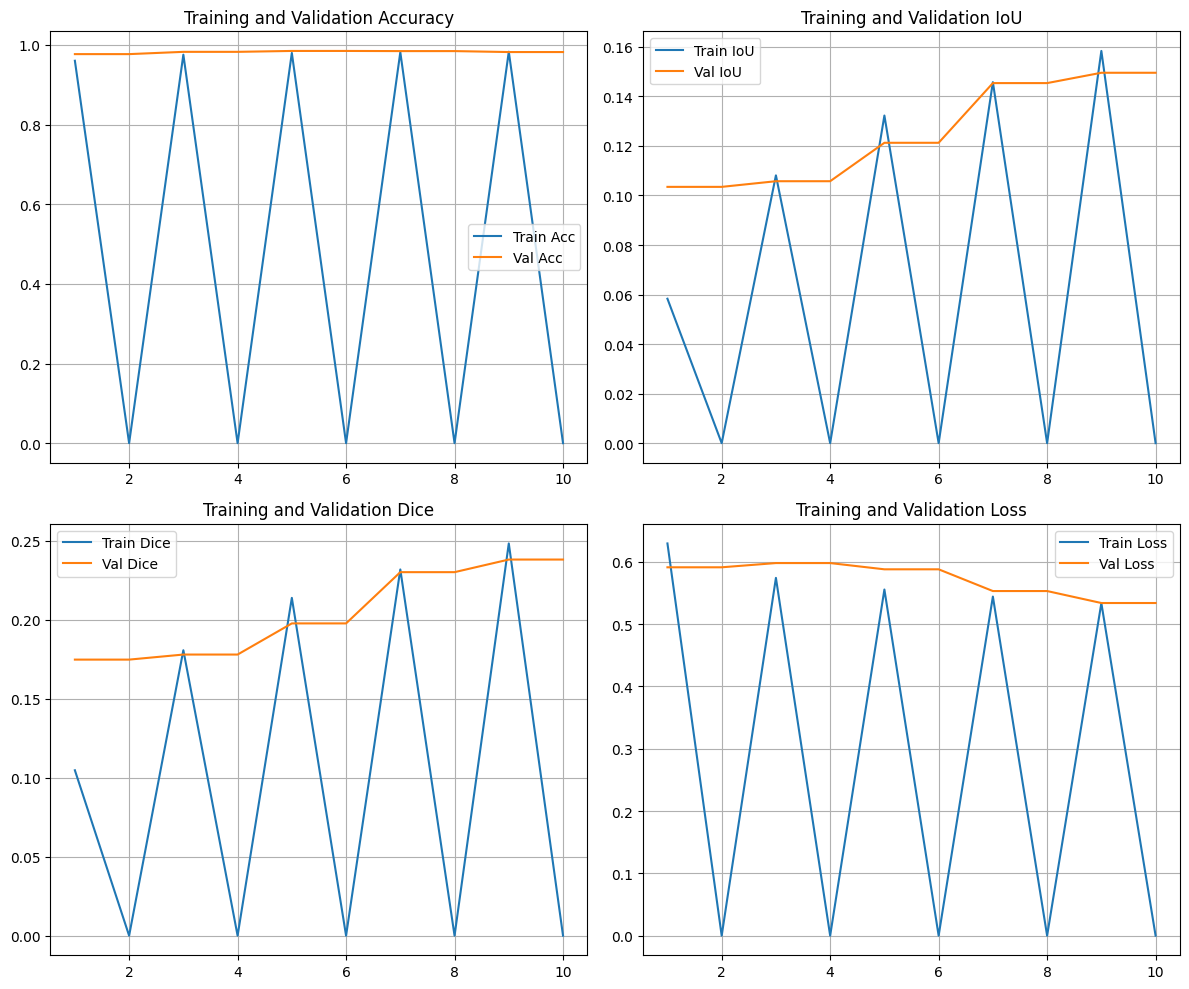

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


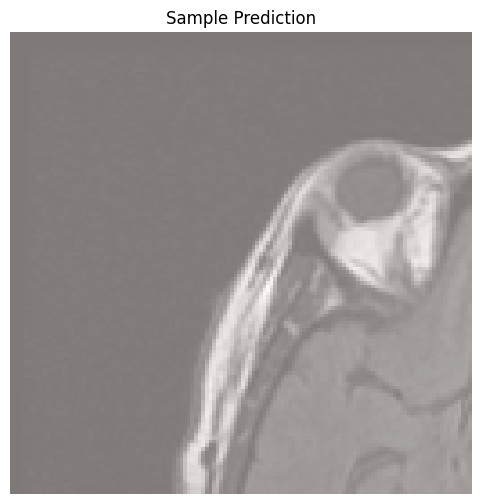


========== 3DUX-Netw/EffiDec3D ==========


Model: "3dux_EffiDec3D_DynamicNAS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_3 (InputLayer)        │ (None, 5, 128, 128, 1)       │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_75 (Conv3D)                │ (None, 5, 128, 128, 16)      │               448 │ input_layer_3[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_30            │ (None, 5, 128, 128, 16)      │                64 │ conv3d_75[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_30 (ReLU)                   │ (None, 5, 128, 128, 16)      │                 0 │ batch_normalization_30[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_77 (Conv3D)                │ (None, 5, 128, 128, 16)      │                32 │ input_layer_3[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_76 (Conv3D)                │ (None, 5, 128, 128, 16)      │             6,928 │ re_lu_30[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_32            │ (None, 5, 128, 128, 16)      │                64 │ conv3d_77[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_31            │ (None, 5, 128, 128, 16)      │                64 │ conv3d_76[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_21 (Add)                      │ (None, 5, 128, 128, 16)      │                 0 │ batch_normalization_32[0][
│                                   │                              │                   │ batch_normalization_31[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_31 (ReLU)                   │ (None, 5, 128, 128, 16)      │                 0 │ add_21[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling3d_9 (MaxPooling3D)    │ (None, 5, 64, 64, 16)        │                 0 │ re_lu_31[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv3d_78 (Conv3D)                │ (None, 5, 64, 64, 32)        │            13,856 │ max_pooling3d_9[0][0]     
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_33            │ (None, 5, 64, 64, 32)        │               128 │ conv3d_78[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ re_lu_32 (ReLU)                   │ (None, 5, 64, 64, 

 Total params: 2,315,055 (8.83 MB)

 Trainable params: 2,313,903 (8.83 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 221s 281ms/step - binary_acc_metric: 0.9282 - dice_metric_soft: 0.0734 - iou_metric_soft: 0.0400 - loss: 0.6916 - val_binary_acc_metric: 0.9900 - val_dice_metric_soft: 0.1650 - val_iou_metric_soft: 0.1012 - val_loss: 0.6256
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9900 - val_dice_metric_soft: 0.1650 - val_iou_metric_soft: 0.1012 - val_loss: 0.6256
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 176s 256ms/step - binary_acc_metric: 0.9801 - dice_metric_soft: 0.2224 - iou_metric_soft: 0.1387 - loss: 0.5511 - val_binary_acc_metric: 0.9914 - val_dice_metric_soft: 0.2713 - val_iou_metric_soft: 0.1812 - val_loss: 0.5411
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - binary_acc_metric: 0.0000e+00 - dice_metric_soft: 0.0000e+00 - iou_metric_soft: 0.0000e+00 - loss: 0.0000e+00 - val_binary_acc_metric: 0.9

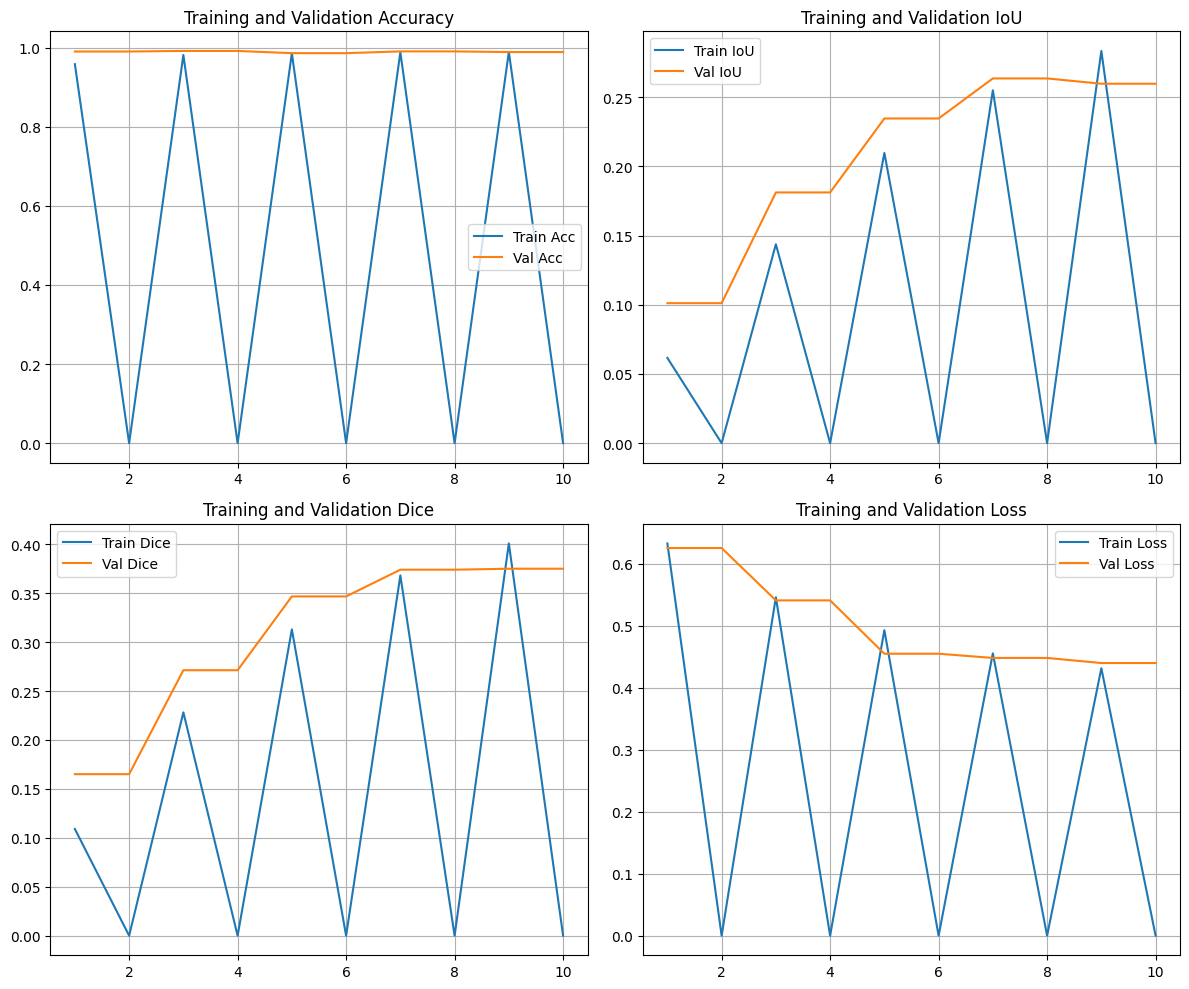

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


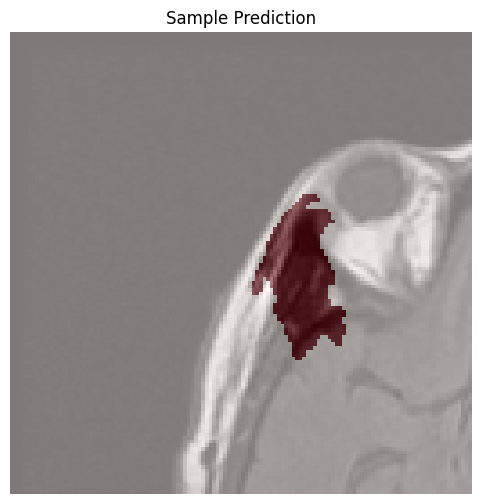


Summary saved to results_dynamicnas_lgg/summary.csv


In [14]:
# ----------------------------
# 9) TRAINING AND EVALUATION LOOP
# ----------------------------
if __name__=="__main__":
    # 1) Define 4 encoder variants for comparison
    encoders = {
        "mednext"     : "MedNeXtMK3w/EffiDec3D",
        "swinunetr"   : "SwinUNETRw/EffiDec3D",
        "swinunetrv2" : "SwinUNETRv2w/EffiDec3D",
        "3dux"        : "3DUX-Netw/EffiDec3D",
    }

    histories = {}     # Store training history for each model
    summary_rows = []  # Store metrics summary for each model

    # 2) Determine suitable batch size for testing
    ts_length = len(test_df)
    candidates = [ts_length//n for n in range(1, ts_length+1) if ts_length%n==0 and ts_length//n<=80]
    test_batch_size = max(sorted(candidates)) if len(candidates) > 0 else min(ts_length, 80)
    test_steps = ts_length // test_batch_size
    print(f"Test sizing -> ts_length={ts_length}, test_batch_size={test_batch_size}, test_steps={test_steps}")

    # 3) Loop over each encoder variant
    for key, label in encoders.items():
        print(f"\n========== {label} ==========")

        # 3a) Build the DynamicNAS model for current encoder
        model = build_dynamicnas_model(shape=(depth, img_size[0], img_size[1], 1), enc_type=key)
        model.summary(line_length=120)

        # 3b) Compile the model with custom weighted BCE + Dice loss and metrics
        model.compile(
            optimizer=keras.optimizers.Adam(lr),
            loss=weighted_bce_dice_loss(pos_weight=10.0),
            metrics=[binary_acc_metric, iou_metric_soft, dice_metric_soft]
        )

        # 3c) Train the model
        hist = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=num_epochs,
            steps_per_epoch=max(1, int(train_steps)),
            validation_steps=max(1, int(val_steps)),
            verbose=1
        )
        histories[label] = hist.history  # Save history for plotting later

        # 3d) Save model weights
        safe_label = label.replace('/', '_').replace(' ', '_')
        weights_path = os.path.join(save_dir, f"{safe_label}.weights.h5")
        model.save_weights(weights_path)
        print(f"Saved weights to {weights_path}")

        # ----------------------------
        # 4) Evaluate model on train, val, and test sets
        # ----------------------------
        train_score = model.evaluate(train_ds, steps=test_steps, verbose=1)
        val_score   = model.evaluate(val_ds, steps=test_steps, verbose=1)
        test_score  = model.evaluate(test_ds, steps=test_steps, verbose=1)

        # Print evaluation metrics
        print(f"\nTrain Loss: {train_score[0]:.4f}, Acc: {train_score[1]:.4f}, IoU: {train_score[2]:.4f}, Dice: {train_score[3]:.4f}")
        print(f"Val   Loss: {val_score[0]:.4f}, Acc: {val_score[1]:.4f}, IoU: {val_score[2]:.4f}, Dice: {val_score[3]:.4f}")
        print(f"Test  Loss: {test_score[0]:.4f}, Acc: {test_score[1]:.4f}, IoU: {test_score[2]:.4f}, Dice: {test_score[3]:.4f}")

        # 5) Compute per-case Dice and HD95 for test dataset
        case_eval = binary_eval_on_dataset(model, test_ds)
        print(f"Per-case evaluation -> Dice: {case_eval['dice_mean']:.4f} ± {case_eval['dice_std']:.4f}, "
              f"HD95: {case_eval['hd95_mean']:.4f} ± {case_eval['hd95_std']:.4f}")

        # 6) Store summary metrics for this model
        summary_rows.append({
            "Model": label,
            "Train Loss": train_score[0],
            "Train Dice": train_score[3],
            "Val Loss": val_score[0],
            "Val Dice": val_score[3],
            "Test Dice": case_eval['dice_mean'],
            "HD95": case_eval['hd95_mean']
        })

        # 7) Plot training history (Accuracy, IoU, Dice, Loss)
        plot_training_history(hist.history, save_path=os.path.join(save_dir, f"{safe_label}_training.png"))

        # 8) Sample prediction visualization for qualitative check
        sample_img = test_df['images_paths'].iloc[0]  # Take first test slice
        inp, disp_img = prepare_input_for_model(sample_img, model, resize_to=img_size, display_size=display_size)
        pred_logits = model.predict(inp)
        pred_mask = (tf.nn.sigmoid(pred_logits[0, depth//2, ..., 0]).numpy() > 0.5).astype(np.uint8)
        plot_prediction(disp_img, pred_mask, alpha=0.5,
                        save_path=os.path.join(save_dir, f"{safe_label}_sample_pred.png"))

    # 9) Save summary of all models to CSV
    summary_df = pd.DataFrame(summary_rows)
    summary_csv = os.path.join(save_dir, "summary.csv")
    summary_df.to_csv(summary_csv, index=False)
    print(f"\nSummary saved to {summary_csv}")
